# Лабораторная работа №1-2. Парсинг Yahoo Finance

**Цель работы:** научиться извлекать данные с веб-страниц, которые подгружают контент динамически с помощью JavaScript. Освоить использование библиотеки `Selenium` для управления браузером и языка `XPath` для точного поиска элементов на странице.

**Вариант задания: 16**
<br>**Бизнес-кейс**: Исследование рынка фриланса: анализ проектов.
<br>**Источник данных для парсинга**: Kwork.ru, раздел "Разработка и IT". Обработать 2-3 страницы.
<br>**Аналитическая задача**: Собрать название услуги, цену и количество
выполненных заказов. Найти самые востребованные услуги.


## Часть 1: Теоретические основы XPath

### Что такое XPath?

**XPath (XML Path Language)** — это язык запросов, предназначенный для навигации по элементам и атрибутам в XML и HTML документах. Представьте HTML-страницу как дерево, состоящее из вложенных друг в друга тегов. XPath предоставляет синтаксис, похожий на путь в файловой системе, чтобы точно указать, какой элемент или группу элементов мы хотим найти в этом дереве.

Для веб-скрапинга XPath является мощным инструментом, позволяющим создавать надежные "селекторы" (указатели) для извлечения нужных данных, даже если структура страницы сложная.

### Основной синтаксис XPath

| Выражение | Описание | Пример |
|:---|:---|:---|
| `//` | Выбирает узлы в документе, начиная с текущего, которые соответствуют выбору, где бы они ни находились. | `//table` (найти все таблицы на странице) |
| `tagname` | Выбирает все узлы с заданным именем тега. | `//tr` (найти все строки таблицы) |
| `.` | Выбирает текущий узел. | - |
| `@` | Выбирает атрибуты. | `//button[@aria-label='Next Link']` (найти кнопку с атрибутом `aria-label`, равным 'Next Link') |
| `[...]` | Предикат для фильтрации. Позволяет указать точные условия. | `//tr[1]` (найти первую строку таблицы) |
| `text()` | Выбирает текстовое содержимое узла. | - |
| `contains()` | Функция, которая позволяет искать частичное совпадение текста в атрибуте или содержимом. | `//button[contains(@class, 'active')]` (найти кнопку, у которой класс *содержит* слово 'active') |

В нашей практической части мы будем использовать комбинации этих выражений для поиска таблицы, кнопок навигации и извлечения данных из ячеек.

## Часть 2: Практика - Парсинг с помощью Selenium

В этой части мы напишем скрипт, который будет:
1. Управлять браузером Chrome в среде Google Colab.
2. Открывать страницу `website-repair` на Kwork.
3. Собирать данные об услугах.
5. Сохранять результат в Excel-файл.

In [2]:
# Шаг 2.1. Установка Selenium и настройка WebDriver для Google Colab

# Устанавливаем библиотеку Selenium
!pip install selenium

# Устанавливаем веб-драйвер для Chrome.
# В Colab нет графического интерфейса, поэтому браузер будет работать в "headless" режиме.
!apt-get update
!apt install chromium-chromedriver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 28.8 MB/s eta 0:00:00
Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illi

#####<font color = "green"> Для отладки кода в Шаг 2 воспользовалась помощью Gemini: это касалось шага "# Шаг 3: Извлечение данных". Вопрос был в правильном обращении к ячейкам карточек, т.к. они не являются классической таблицей. В коде от ИИ исправила только типы классов с div на p, span </font>

In [12]:
# Шаг 2.2. Запуск скрипта для сбора данных с Kwork.ru

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import pandas as pd

# --- Настройка опций для запуска Chrome в Google Colab ---
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36")
# --------------------------------------------------------

driver = webdriver.Chrome(options=chrome_options)
driver.maximize_window()

url = 'https://kwork.ru/categories/website-repair'

try:
    print(f"Переход на страницу: {url}")
    driver.get(url)
    wait = WebDriverWait(driver, 30)

    # Шаг 1: Обработка всплывающего окна cookie (если оно появится)
    try:
        print("Поиск окна согласия на cookie...")
        # Используем более общий селектор, который подходит для разных текстов на кнопке
        agree_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//button[contains(., 'Agree')] | //button[contains(., 'Accept all')]")))
        agree_button.click()
        print("Кнопка согласия нажата.")
    except TimeoutException:
        print("Окно согласия не найдено или уже принято. Продолжаем...")

    # шаг 2 удален, т.к. на сайте нет таблицы. Смотрим данные по карточкам, которые отображаются сразу

    # Шаг 3: Извлечение данных
    print("Извлечение данных...")
    # Находим все элементы для каждой колонки отдельно. Используем XPath для карточек услуг.
    # Название услуги
    titles = [el.text for el in driver.find_elements(By.XPATH, '//p[@class="kwork-card-item__title"]')]
    # Количество выполненных заказов
    orders = [el.text for el in driver.find_elements(By.XPATH, '//span[@class="kwork-card-item__rating-count"]')]
    # Цена
    prices = [el.text for el in driver.find_elements(By.XPATH, '//span[@class="price-wrap__value force-font force-font--s15"]')]


    # Шаг 4: Создание и сохранение DataFrame
    min_len = min(len(titles), len(orders), len(prices))
    data = {
        'Title': titles[:min_len], 'Completed Orders': orders[:min_len], 'Price': prices[:min_len]
    }
    df = pd.DataFrame(data)

    print(f"\nВсего собрано {len(df)} строк.")
    output_filename = 'kwork_website_repair.xlsx'
    df.to_excel(output_filename, index=False)
    print(f"Данные успешно сохранены в файл: {output_filename}")
    print("Файл можно найти в панели слева ('Файлы').")

except Exception as e:
    print(f"Произошла ошибка: {e}")
    # Делаем скриншот для отладки в случае ошибки
    driver.save_screenshot('error_screenshot.png')
    print("Сделан скриншот 'error_screenshot.png' для отладки.")

finally:
    print("Закрытие браузера...")
    driver.quit()

Переход на страницу: https://kwork.ru/categories/website-repair
Поиск окна согласия на cookie...
Окно согласия не найдено или уже принято. Продолжаем...
Извлечение данных...

Всего собрано 24 строк.
Данные успешно сохранены в файл: kwork_website_repair.xlsx
Файл можно найти в панели слева ('Файлы').
Закрытие браузера...


## Часть 3: Анализ полученных данных



In [14]:
# Шаг 3.1: Загрузка и первичный осмотр данных

import pandas as pd

try:
    file_path = 'kwork_website_repair.xlsx'
    df = pd.read_excel(file_path)

    print(f"Файл '{file_path}' успешно загружен.")
    print(f"Размер таблицы: {df.shape[0]} строк, {df.shape[1]} колонок.")

    print("\nПервые 5 строк таблицы:")
    display(df.head())

    print("\nТипы данных в колонках:")
    df.info()

except FileNotFoundError:
    print(f"Ошибка: файл '{file_path}' не найден. Убедитесь, что предыдущая ячейка отработала успешно и файл создан.")

Файл 'kwork_website_repair.xlsx' успешно загружен.
Размер таблицы: 24 строк, 3 колонок.

Первые 5 строк таблицы:


,Title,Completed Orders,Price
0,Доработка сайта на MODX CMF,(222),1 000 ₽
1,Настройка и доработка WordPress,(2K+),1 500 ₽
2,Доработка сайта по ТЗ или Аудиту на TiIda,(200),2 000 ₽
3,"Лечение сайта на 1С Битрикс, удаление вирусов,...",(2K+),6 000 ₽
4,Исправлю ошибку на сайте,(272),1 000 ₽



Типы данных в колонках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title             24 non-null     object
 1   Completed Orders  24 non-null     object
 2   Price             24 non-null     object
dtypes: object(3)
memory usage: 708.0+ bytes


In [34]:
# Шаг 3.2: Предварительная обработка данных
import unicodedata

df_clean = df.copy()

# 2. Очистка 'Completed Orders' и 'Price'
df_clean['Completed Orders'] = df_clean['Completed Orders'].astype(str).str.replace(r'[()+]', '', regex=True)

# Removing the Russian Ruble symbol and any non-digit characters except space (for thousands separator)
df_clean['Price'] = df_clean['Price'].astype(str).str.replace(r'[^\d\s]', '', regex=True).str.strip()

# Removing space as thousands separator
df_clean['Price'] = df_clean['Price'].str.replace(r'\s', '', regex=True)


# 3. Преобразование колонок в числовой формат
# Only 'Price' and 'Completed Orders' need conversion for Kwork data
cols_to_numeric = ['Price']
for col in cols_to_numeric:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Need to handle 'K' in 'Completed Orders' before converting to numeric
def convert_orders(orders_str):
    orders_str = str(orders_str).strip().upper()
    if orders_str.endswith('K'):
        return float(orders_str[:-1]) * 1000
    elif orders_str.endswith('+'): # Handle cases like '2K+' этот шаг не нужен, т.к. убрали знак + при помощи regex
         return float(orders_str[:-1]) * 1000
    return pd.to_numeric(orders_str, errors='coerce')

df_clean['Completed Orders'] = df_clean['Completed Orders'].apply(convert_orders)

# Удаляем строки, где могли возникнуть ошибки преобразования (стали NaN)
# Updated subset for Kwork data
df_clean.dropna(subset=['Price', 'Completed Orders'], inplace=True)

# 5. Преобразуем 'Completed Orders' and 'Price' to integer if possible
df_clean['Completed Orders'] = df_clean['Completed Orders'].astype('int64')
df_clean['Price'] = df_clean['Price'].astype('int64')


print("--- ДАННЫЕ ПОСЛЕ ОЧИСТКИ ---")
df_clean.info()
print(df_clean.head())

--- ДАННЫЕ ПОСЛЕ ОЧИСТКИ ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title             24 non-null     object
 1   Completed Orders  24 non-null     int64 
 2   Price             24 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 708.0+ bytes
                                               Title  Completed Orders  Price
0                        Доработка сайта на MODX CMF               222   1000
1                    Настройка и доработка WordPress              2000   1500
2          Доработка сайта по ТЗ или Аудиту на TiIda               200   2000
3  Лечение сайта на 1С Битрикс, удаление вирусов,...              2000   6000
4                           Исправлю ошибку на сайте               272   1000


/tmp/ipython-input-1257166222.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Completed Orders', y='Title', data=top_10_orders, palette='viridis')


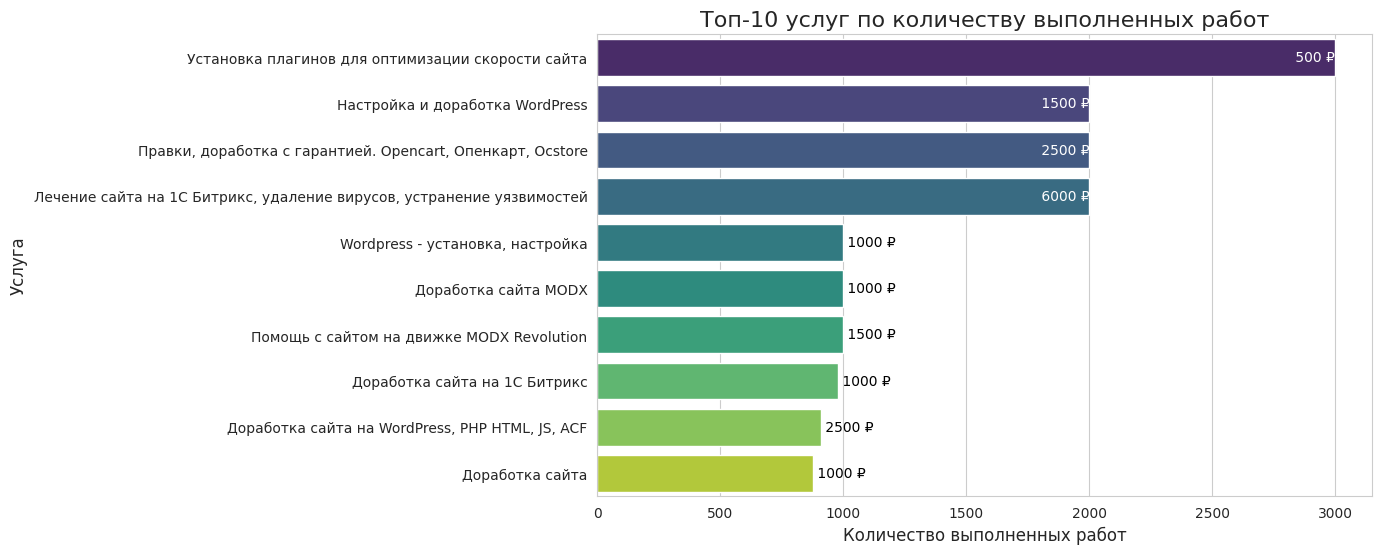

In [40]:
# Шаг 3.3: Анализ и визуализация данных

import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для графиков
sns.set_style("whitegrid")

# --- Анализ 1: Топ-10 услуг по количеству выполненных работ ---
top_10_orders = df_clean.sort_values(by='Completed Orders', ascending=False).head(10).reset_index(drop=True) # Reset index for correct plotting

plt.figure(figsize=(10, 6)) # Увеличим размер графика для лучшей читаемости
ax1 = sns.barplot(x='Completed Orders', y='Title', data=top_10_orders, palette='viridis')
ax1.set_title('Топ-10 услуг по количеству выполненных работ', fontsize=16)
ax1.set_xlabel('Количество выполненных работ', fontsize=12)
ax1.ticklabel_format(style='plain', axis='x') # Отключаем научную нотацию для оси X
ax1.set_ylabel('Услуга', fontsize=12)

# Добавляем подписи с ценой к каждому бару
x_max = ax1.get_xlim()[1] # Get the maximum x-limit of the plot for normalization

for index, row in top_10_orders.iterrows():
    text_x = row['Completed Orders']
    text_y = index
    price_text = f' {row["Price"]} ₽'

    # Determine text color based on whether it's inside the bar
    # This is a simple heuristic; a more precise check would involve bar width
    if text_x / x_max > 0.5: # If text is more than halfway across the plot
        color = 'white'
        ha = 'right' # Align text to the right inside the bar
    else:
        color = 'black'
        ha = 'left' # Align text to the left outside the bar

    ax1.text(text_x, text_y, price_text, color=color, ha=ha, va="center")


plt.show()

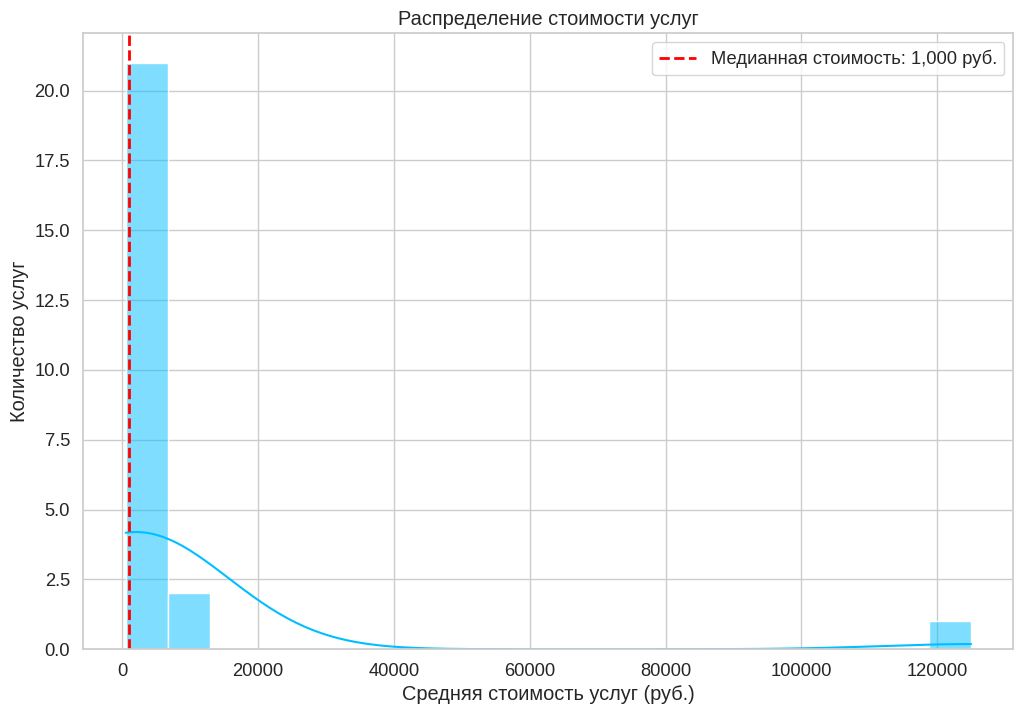

In [42]:
import seaborn as sns
# --- Настройка стиля ---
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans']

fig, ax = plt.subplots(figsize=(12, 8)) # Используем fig, ax для большего контроля

    # --- Построение основного графика ---
sns.histplot(df_clean['Price'], bins=20, kde=True, color='deepskyblue', ax=ax)

median_price = df_clean['Price'].median()
ax.axvline(
        median_price,
        color='red',
        linestyle='--',
        linewidth=2,
        label=f'Медианная стоимость: {median_price:,.0f} руб.'
    )

    # --- Настройка заголовков и подписей ---
ax.set_title('Распределение стоимости услуг')
ax.set_xlabel('Средняя стоимость услуг (руб.)')
ax.set_ylabel('Количество услуг')
ax.legend()


## SQlite

In [62]:
import sqlite3

# df - ваш очищенный DataFrame после парсинга
# 1. Создание соединения с базой данных (файл будет создан,если не существует)

conn = sqlite3.connect('kwork_data.db')

# 2. Сохранение DataFrame в таблицу SQL.
# 'if_exists='replace'' перезапишет таблицу, если она уже существует.

table_name = 'parsed_data'
df_clean.rename({"Completed Orders": "Completed_Orders"}, axis =1).to_sql(table_name, conn, if_exists='replace', index=False)

# 3. Пример SQL-запроса: выбрать топ-5 услуг по цене,отсортированных по убыванию

query = "SELECT * FROM parsed_data ORDER BY Price DESC LIMIT 5"
result_df = pd.read_sql_query(query, conn)
print("Топ-5 самых дорогих услуг:")
display(result_df)

# 4. Закрытие соединения
conn.close()

Топ-5 самых дорогих услуг:


,Title,Completed_Orders,Price
0,AntiBot защита от накрутки поведенческих ботов...,662,125000
1,Правка или доработка сайта на Word Press,84,10000
2,"Обновление WordPress, PHP и плагинов + скорост...",171,10000
3,"Лечение сайта на 1С Битрикс, удаление вирусов,...",2000,6000
4,"Правки, доработка с гарантией. Opencart, Опенк...",2000,2500


In [63]:
conn = sqlite3.connect('kwork_data.db')

query = "SELECT * FROM parsed_data WHERE Title like '%1С Битрикс%' ORDER BY 2 DESC"
result_df = pd.read_sql_query(query, conn)
print("Список услуг, касающихся доработки сайта на 1С Битрикс:")
display(result_df)

conn.close()

Список услуг, касающихся доработки сайта на 1С Битрикс:


,Title,Completed_Orders,Price
0,"Лечение сайта на 1С Битрикс, удаление вирусов,...",2000,6000
1,Доработка сайта на 1С Битрикс,979,1000
2,Доработка сайта на 1С Битрикс,730,1000
3,Недорогая доработка сайта на 1С Битрикс,347,1000
4,Любая доработка и правка сайта 1С Битрикс,347,1000


In [97]:
conn = sqlite3.connect('kwork_data.db')

query = """
SELECT
SUM(Completed_Orders) as Orders_Completed,
SUM(Price*Completed_Orders) as Total_Value,
AVG(Price) as Avg_Price,
SUM(Price*Completed_Orders)/SUM(Completed_Orders) as Weighted_Avg_Price
FROM parsed_data
WHERE Title like '%1С Битрикс%'
"""
result_df = pd.read_sql_query(query, conn)
print("Саммери по работам, связанным с 1С Битрикс:")
display(result_df)

conn.close()

Саммери по работам, связанным с 1С Битрикс:


,Orders_Completed,Total_Value,Avg_Price,Weighted_Avg_Price
0,4403,14403000,2000.0,3271


In [81]:
conn = sqlite3.connect('kwork_data.db')

query = """
WITH CTE AS
(SELECT
SUM(Price*Completed_Orders) as Grand_Total,
SUM(CASE
    WHEN Title like '%1С Битрикс%' then Price*Completed_Orders
    ELSE null
    END) as Bitrix_orders_price
FROM parsed_data)
SELECT
Bitrix_orders_price,
Grand_Total,
Bitrix_orders_price*100/Grand_Total as 'Bitrix_share (%)'
FROM CTE
"""
result_df = pd.read_sql_query(query, conn)
print("На какую сумму выполнено работ по Bitrix, какая доля от общей суммы выполненных работ:")
display(result_df)

conn.close()

На какую сумму выполнено работ по Bitrix, какая доля от общей суммы выполненных работ:


,Bitrix_orders_price,Grand_Total,Bitrix_share (%)
0,14403000,118437500,12


## Выводы

В ходе выполнения лабораторной работы мы успешно решили задачу парсинга данных с веб-сайта Kwork.ru, раздел "Разработка и IT".

1.  **Применили знания XPath** для создания надежных селекторов
2.  **Настроили и использовали Selenium** в Google Colab для автоматизации работы с браузером, включая обработку всплывающих окон и ожидание динамической загрузки контента.
3.  **Извлекли данные** по самым востребованным работам и их стоимости и сохранили их в структурированном виде (Excel-файл).
4.  **Провели комплексную предварительную обработку данных** с помощью Pandas, преобразовав текстовые значения количеств (например, '2K+') и цен с указанием валюты в результатах парсинга в числовые форматы, пригодные для анализа.
5.  **Выполнили базовый анализ и визуализацию**, определив лидеров по объему выполняемых работ, распределению стоимости услуг, общей сстоимости выполненных услуг и доли в ней работ, связанных с доработкой 1С Битрикс.